# Segmentez des clients d'un site e-commerce
## Simulation

In [1]:
# %load_ext pycodestyle_magic
%reload_ext pycodestyle_magic
%pycodestyle_on

## Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

import warnings
warnings.filterwarnings('ignore')

# Create df0 and df1, ..., dfk

In [3]:
orders = pd.read_csv('archive/olist_orders_dataset.csv')

customers = pd.read_csv('archive/olist_customers_dataset.csv')

reviews = pd.read_csv('archive/olist_order_reviews_dataset.csv')

In [4]:
orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [5]:
def generate_tempo_rfm(date_start="2017-01-01",
                       n_days=14,
                       d0=False,
                       n_days_d0=365):
    '''Function generating a RFM Dataframe with customer_unique_id for the
    specified period, from the Olist datasets files'''

    # Changing string call because too long
    delivery_date = 'order_delivered_customer_date'

    # -------- GET DATASETS FROM FILES --------
    orders = pd.read_csv('archive/olist_orders_dataset.csv')
    customers = pd.read_csv('archive/olist_customers_dataset.csv')
    reviews = pd.read_csv('archive/olist_order_reviews_dataset.csv')
    orders_payments = pd.read_csv('archive/olist_order_payments_dataset.csv')

    # -------- CLEANING OF DATASETS --------

    # Clean order delivered dates
    mask_date = (orders[delivery_date] < '2017-01')
    mask_delivered = (orders['order_status'] != 'delivered')
    mask_na = (orders[delivery_date].isna())
    dates_to_drop = orders.loc[mask_delivered | mask_date].index
    orders.drop(dates_to_drop, inplace=True)

    mask_na = (orders[delivery_date].isna())
    orders[delivery_date].loc[mask_na] = orders[delivery_date].loc[mask_na]

    # Sum the payment values for a unique order_id
    payments = orders_payments.groupby('order_id').sum().reset_index()

    # Keep customers and orders ids, and order date for all delivered orders
    customers_infos = ['customer_id',
                       'customer_unique_id']
    orders_infos = ['order_id',
                    'customer_id',
                    'order_purchase_timestamp',
                    delivery_date]

    # Merge all needed datas in df_infos
    df_infos = customers[customers_infos].merge(
        orders[orders_infos], on='customer_id')

    # Add review score by order id to df_info
    df_infos = df_infos.merge(reviews[['order_id', 'review_score']],
                              on='order_id')

    # Add summed payment values by order id to df_info
    df_infos = df_infos.merge(payments[['order_id',
                                        'payment_value']], on='order_id')

    # Conversion of used dates to datetime format
    date_start = pd.to_datetime(date_start)

    df_infos['order_purchase_timestamp'] =\
        pd.to_datetime(df_infos['order_purchase_timestamp'])
    df_infos[delivery_date] = pd.to_datetime(df_infos[delivery_date])

    # -------- CREATION OF d0 DATAFRAME --------
    end_date = date_start + pd.DateOffset(days=n_days_d0)
    mask_start = df_infos[delivery_date] > date_start
    mask_end = df_infos[delivery_date] < end_date
    rfm_matrix = pd.DataFrame()

    data = df_infos.loc[mask_start & mask_end]
    rfm_matrix['Recency'] = data.groupby('customer_unique_id')[
        'order_purchase_timestamp'].agg('last')
    rfm_matrix['Frequency'] = data.groupby(
        'customer_unique_id')['order_id'].count()
    rfm_matrix['Monetary value'] = data.groupby(
        'customer_unique_id')['payment_value'].sum()
    rfm_matrix['Review score'] = data.groupby(
        'customer_unique_id')['review_score'].mean()
    rfm_matrix['Recency'] = (rfm_matrix['Recency'].max() -
                             rfm_matrix['Recency']).dt.days
    df0 = pd.DataFrame(rfm_matrix)

    if d0 is True:
        return df0

    else:
        # -------- DIVISION OF PERIODS --------
        # From start_date to date delivered max with n_days period
        end_dates = []
        current_date = date_start + pd.DateOffset(days=n_days_d0)

        while current_date <= df_infos[delivery_date].max():
            end_dates.append(current_date + pd.DateOffset(days=n_days))
            current_date += pd.DateOffset(days=n_days+1)

        # -------- CREATE RFM MATRIX --------
        i = 1
        dfs = {}
        mask_start = df_infos[delivery_date] > date_start

        # Creation of each dataframes from end dates
        for end_date in end_dates:
            print(end_date)
            rfm_matrix = pd.DataFrame()
            mask_end = df_infos[delivery_date] < end_date
            df_name = f'df{i}'

            data = df_infos.loc[mask_start & mask_end]
            rfm_matrix['Recency'] = data.groupby('customer_unique_id')[
                'order_purchase_timestamp'].agg('last')
            rfm_matrix['Frequency'] = data.groupby(
                'customer_unique_id')['order_id'].count()
            rfm_matrix['Monetary value'] = data.groupby(
                'customer_unique_id')['payment_value'].sum()
            rfm_matrix['Review score'] = data.groupby(
                'customer_unique_id')['review_score'].mean()
            rfm_matrix['Recency'] = (rfm_matrix['Recency'].max() -
                                     rfm_matrix['Recency']).dt.days
            dfs[df_name] = pd.DataFrame(rfm_matrix)
            i = i + 1

        return dfs

In [6]:
df0 = generate_tempo_rfm(date_start='2017-01-01', d0=True, n_days_d0=365)
df0

,Recency,Frequency,Monetary value,Review score
customer_unique_id,,,,
0000f46a3911fa3c0805444483337064,292,1,86.22,3.0
0000f6ccb0745a6a4b88665a16c9f078,76,1,43.62,4.0
0004aac84e0df4da2b147fca70cf8255,43,1,196.89,5.0
0005e1862207bf6ccc02e4228effd9a0,298,1,150.12,4.0
0006fdc98a402fceb4eb0ee528f6a8d4,163,1,29.00,3.0
...,...,...,...,...
fffa431dd3fcdefea4b1777d114144f2,58,1,81.20,5.0
fffb09418989a0dbff854a28163e47c6,10,1,73.16,5.0
fffcf5a5ff07b0908bd4e2dbc735a684,202,1,2067.42,5.0


In [7]:
dfs = generate_tempo_rfm()

2018-01-15 00:00:00
2018-01-30 00:00:00
2018-02-14 00:00:00
2018-03-01 00:00:00
2018-03-16 00:00:00
2018-03-31 00:00:00
2018-04-15 00:00:00
2018-04-30 00:00:00
2018-05-15 00:00:00
2018-05-30 00:00:00
2018-06-14 00:00:00
2018-06-29 00:00:00
2018-07-14 00:00:00
2018-07-29 00:00:00
2018-08-13 00:00:00
2018-08-28 00:00:00
2018-09-12 00:00:00
2018-09-27 00:00:00
2018-10-12 00:00:00
2018-10-27 00:00:00


(41871, 4)
(45172, 4)
(47761, 4)
(51381, 4)
(54435, 4)
(57851, 4)
(61675, 4)
(65069, 4)
(68977, 4)
(72205, 4)
(75100, 4)
(78436, 4)
(81532, 4)
(83731, 4)
(87075, 4)
(91330, 4)
(92476, 4)
(92492, 4)
(92495, 4)
(92496, 4)


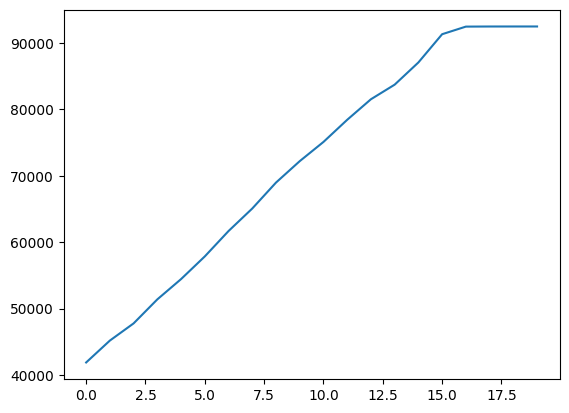

In [8]:
sizes = []

for key, df in dfs.items():
    sizes.append(df.shape[0])
    print(df.shape)

plt.plot(sizes)

# General Model

In [9]:
kmeans = KMeans(n_clusters=5)

In [10]:
sc0 = StandardScaler().fit(df0.values)
X0 = sc0.transform(df0.values)
M0 = kmeans.fit(X0)
labels = M0.predict(X0)

# Time shift models

In [11]:
ari_score = []
for key, df in dfs.items():
    X0 = sc0.transform(df.values)
    X = StandardScaler().fit_transform(df.values)

    M = kmeans.fit(X)

    ari = adjusted_rand_score(M0.predict(X0), M.predict(X))
    ari_score.append(ari)

In [12]:
ari_score

[0.9359322524716432,
 0.8983127855706109,
 0.8608664003575993,
 0.8166290995187153,
 0.7820725041169847,
 0.7591840888425073,
 0.7446060716048679,
 0.7229940580212582,
 0.6544389611432396,
 0.5921681199032468,
 0.5747337920840008,
 0.5441657780301596,
 0.4955118430899758,
 0.45198735131776857,
 0.4308883476269633,
 0.47892995926543186,
 0.47270926651625594,
 0.4727420414803635,
 0.4727375955211297,
 0.47273267761931453]

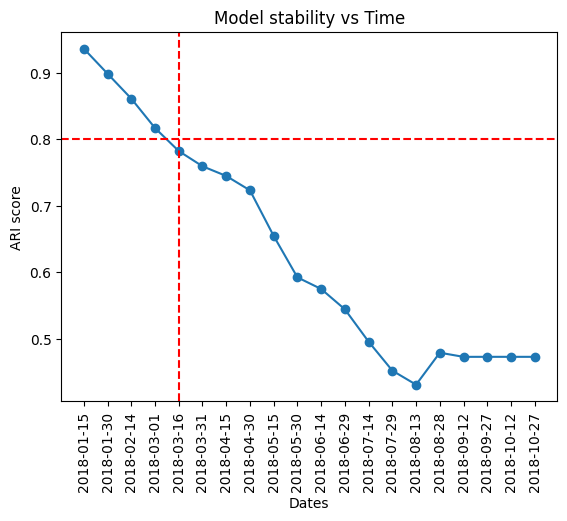

In [32]:
# Find the index from which the values are < 0.8
index = None
for i in range(len(ari_score)):
    if ari_score[i] < 0.8:
        index = i
        break

dates = pd.date_range(start='2018-01-15',
                      end='2018-10-27',
                      freq='15D')
formatted_dates = [date.strftime('%Y-%m-%d') for date in dates]

# Plot the graph
plt.plot(formatted_dates, ari_score, marker='o')

# Add a vertical line to the index
if index is not None:
    plt.axvline(x=index, color='red', linestyle='--')

# Add a horizontal line to the value 0.8
plt.axhline(y=0.8, color='red', linestyle='--')

# graph configuration
plt.xlabel('Dates')
plt.xticks(rotation=90)
plt.ylabel('ARI score')
plt.title('Model stability vs Time')

plt.show()

En fixant une limite de performance à 0.80, on considère que le modèle deviendra obsolète au bout de 5 x 2 semaines= 2.5 mois. On arrondi à 3 mois pour proposer une maintenance.